## Sim Demo

### Imports

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from env.imports import *

In [44]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [45]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 2.9%
RAM Usage: 5.3%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [46]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.05 GB


In [47]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  3% |


In [48]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

In [49]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

In [50]:
X = load_transcriptome(parcellation='S400', hemisphere='both', omit_subcortical=False, sort_genes='chromosome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S400', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S400', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S400', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_index_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X = X[valid_indices]
Y = Y[valid_indices][:, valid_indices]
coords = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]


In [51]:
# Project X to 27 PCs
pca = PCA(n_components=27)
X_pca = pca.fit_transform(X)
print(f"X_pca shape: {X_pca.shape}")

X_pca shape: (455, 27)


In [52]:
# Project X to 10 PLS components
pls_model = PLSRegression(n_components=10, max_iter=1000, scale=True)
pls_model.fit(X, Y)

# Use x_rotations_ for fixed projection like in PLSEncoder
X_pls = np.matmul(X, pls_model.x_rotations_)
print(f"X_pls shape: {X_pls.shape}")


X_pls shape: (455, 10)


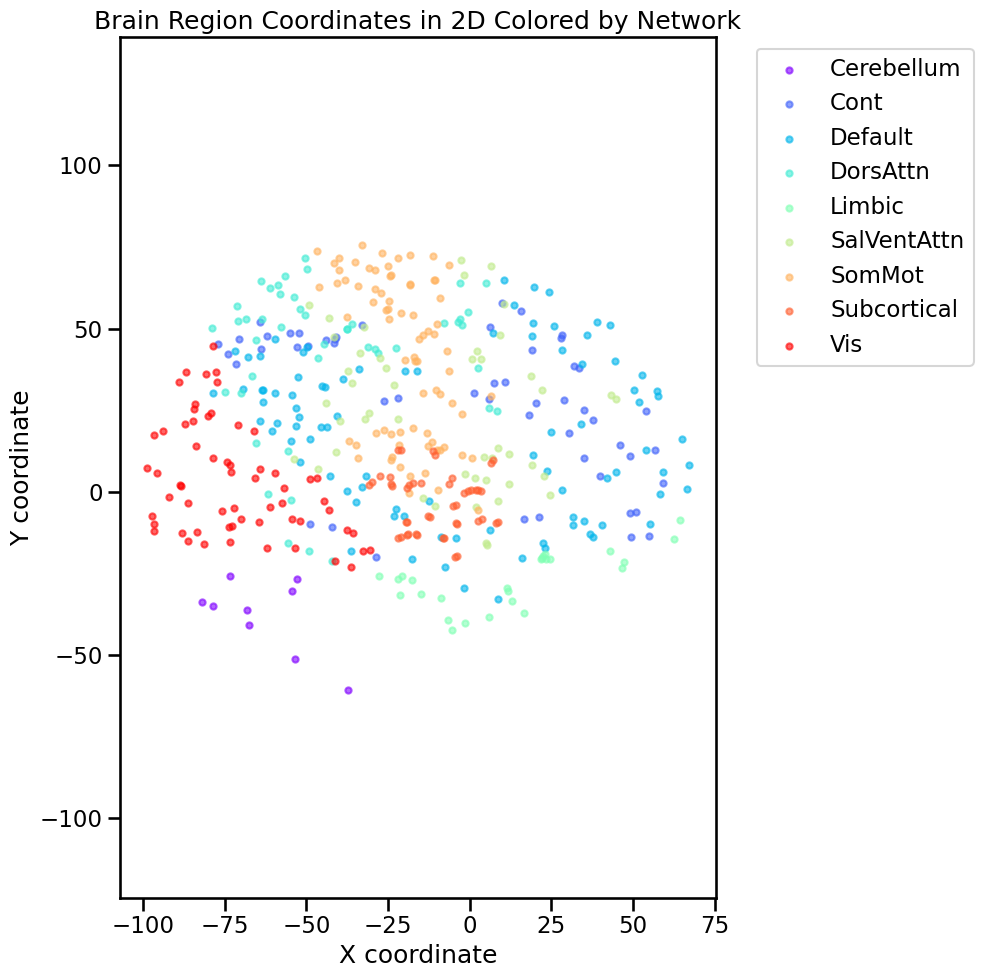

In [53]:
# Plot coordinates in 2D colored by network
plt.figure(figsize=(10, 10))

# Get unique networks for coloring
unique_networks = np.unique(network_labels)

# Create color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))

# Plot each network with different color
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    plt.scatter(coords[mask, 1], coords[mask, 2], 
               alpha=0.6,
               s=20, # Make points smaller
               label=network,
               color=color)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Brain Region Coordinates in 2D Colored by Network')
plt.axis('equal')  # Keep aspect ratio equal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

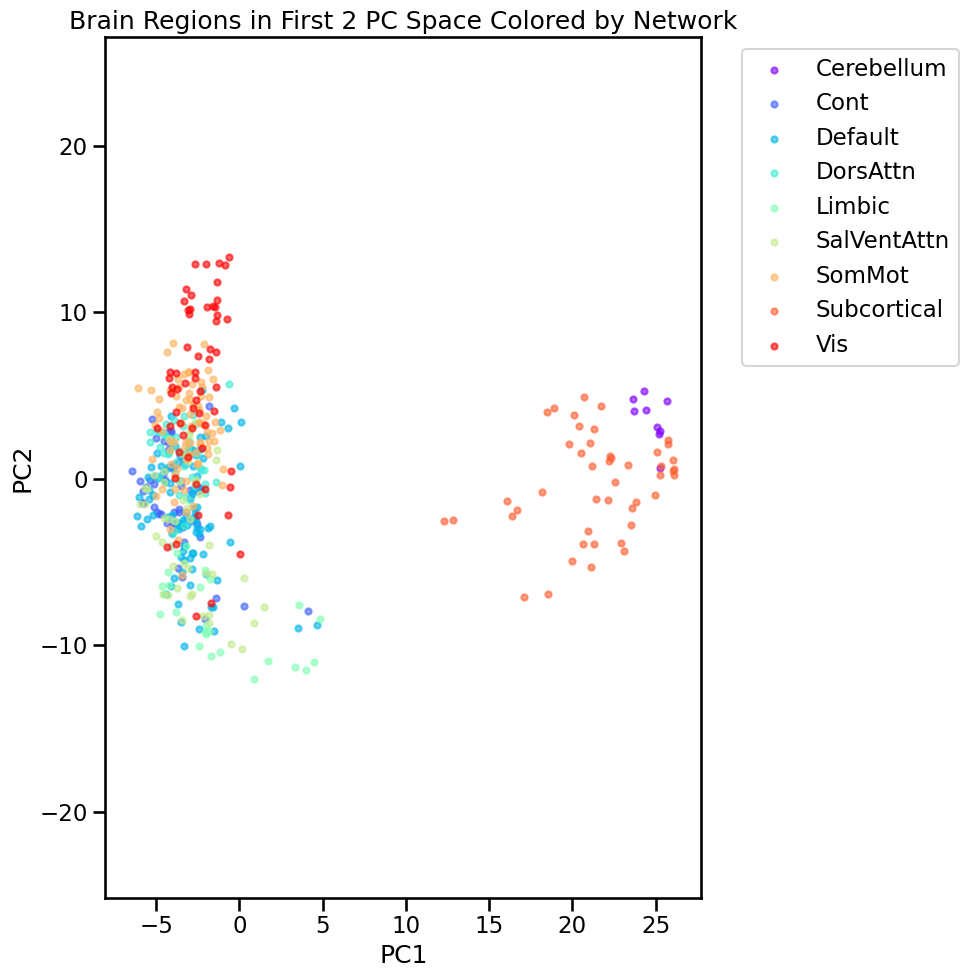

In [54]:
# Plot nodes in first 2 PC space colored by network
plt.figure(figsize=(10, 10))

# Get unique networks for coloring
unique_networks = np.unique(network_labels)

# Create color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))

# Plot each network with different color
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               alpha=0.6, 
               s=20, # Make points smaller
               label=network,
               color=color)

plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Brain Regions in First 2 PC Space Colored by Network')
plt.axis('equal')  # Keep aspect ratio equal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

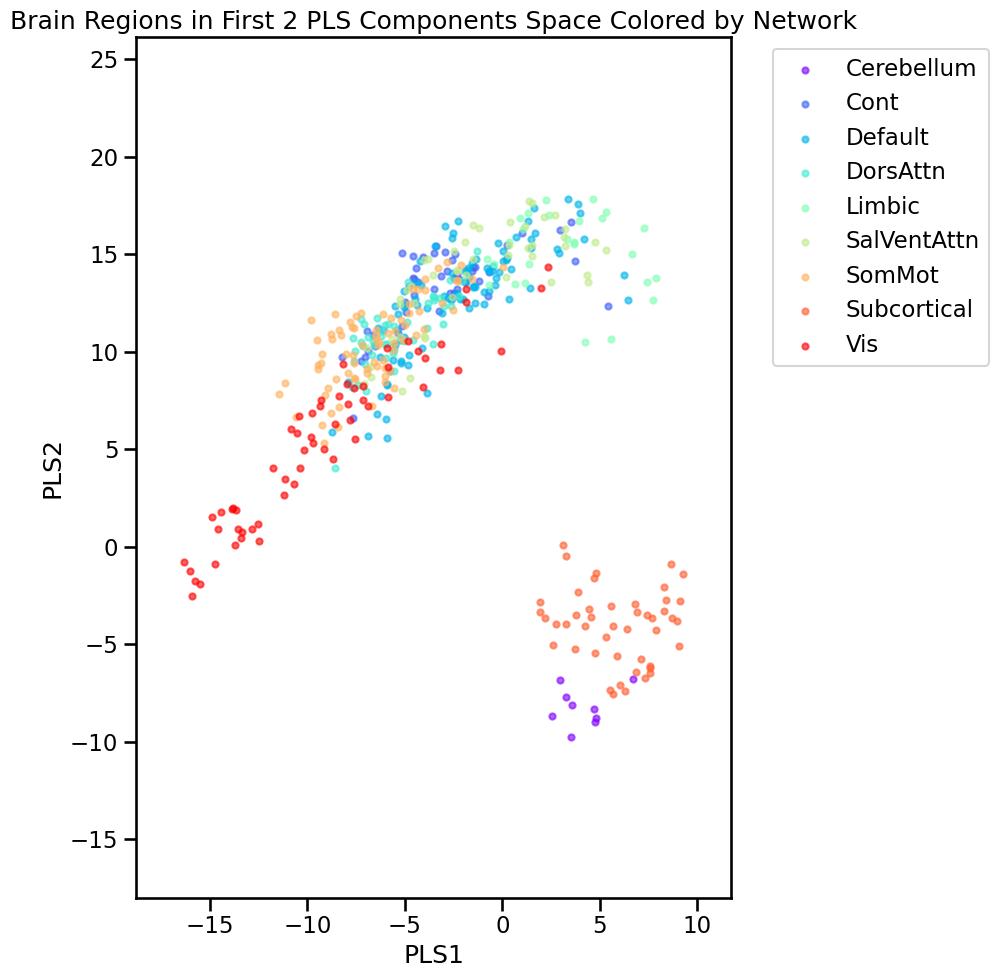

In [55]:
# Plot nodes in first 2 PLS components space colored by network
plt.figure(figsize=(10, 10))

# Get unique networks for coloring
unique_networks = np.unique(network_labels)

# Create color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))

# Plot each network with different color
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    plt.scatter(X_pls[mask, 0], X_pls[mask, 1],
               alpha=0.6, 
               s=20, # Make points smaller
               label=network,
               color=color)

plt.xlabel('PLS1')
plt.ylabel('PLS2') 
plt.title('Brain Regions in First 2 PLS Components Space Colored by Network')
plt.axis('equal')  # Keep aspect ratio equal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [56]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset


In [57]:
parcellation = 'S400'
omit_subcortical = False

# Load data
print("Loading data...")
X = load_transcriptome(
    parcellation=parcellation, 
    omit_subcortical=omit_subcortical,
    hemisphere='both', 
    impute_strategy='mirror_interpolate'
)

Y_fc = load_connectome(
    parcellation=parcellation,
    omit_subcortical=omit_subcortical,
    measure='FC',
    hemisphere='both'
)

coords = load_coords(
    parcellation=parcellation,
    omit_subcortical=omit_subcortical,
    hemisphere='both'
)

# Filter out regions with missing gene expression data
valid_mask = ~np.isnan(X).any(axis=1)
print(f"Subsetting based on gene expression (X)")

valid_indices = np.where(valid_mask)[0]
print(f"Found {len(valid_indices)} valid regions out of {X.shape[0]}")

if len(valid_indices) == 0:
    raise ValueError("No valid regions found after filtering. Check your data.")

# Create mapping from valid indices to original indices
valid2true_mapping = {i: valid_indices[i] for i in range(len(valid_indices))}

# Subset data to only include valid regions
X_valid = X[valid_indices]
Y_fc_valid = Y_fc[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]

# Create training/validation/test splits
n_regions = len(valid_indices)
n_pairs = (n_regions * (n_regions - 1)) // 2

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_fc_valid, 
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping
)

batch_size = 512
# Create dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

Loading data...
Subsetting based on gene expression (X)
Found 455 valid regions out of 456
Creating RegionPairDataset...


In [58]:
from torch.utils.data import Subset

# Use the first 256 samples, or fewer if you like
subset_indices = list(range(1024))
subset_dataset = Subset(dataset, subset_indices)

subset_loader = DataLoader(
    subset_dataset,
    batch_size=256,            # Smaller batch to avoid GPU memory overflow
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [59]:
from models.transformer_models import SharedSelfAttentionCLSModel

# Set up model with the same hyperparameters used for training
model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_full_model.pt"))
model.eval()
model.to("cuda")

  warnings.warn(



SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

In [60]:

embeddings = []
seen_coords = set()

model.eval()
with torch.no_grad():
    for batch_X, batch_y, batch_coords, _ in subset_loader:
        batch_X = batch_X.to(model.device)
        batch_coords = batch_coords.to(model.device)

        x_i, x_j = torch.chunk(batch_X, chunks=2, dim=1)
        coords_i, coords_j = torch.chunk(batch_coords, chunks=2, dim=1)

        # Process each unique coordinate in the batch
        for x, coords in [(x_i, coords_i), (x_j, coords_j)]:
            for i in range(len(coords)):
                coord_tuple = tuple(coords[i].cpu().numpy())
                if coord_tuple not in seen_coords:
                    # Get encoded region embedding for new coordinate
                    emb = model.encoder(x[i:i+1], coords[i:i+1])  # (1, dim)
                    embeddings.append(emb.cpu())
                    seen_coords.add(coord_tuple)

# Stack all embeddings
embeddings = torch.cat(embeddings, dim=0).numpy()


In [61]:
embeddings.shape

(455, 1240)

In [68]:
X = load_transcriptome(parcellation='S400', hemisphere='both', omit_subcortical=False, sort_genes='chromosome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S400', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S400', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S400', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_index_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X = X[valid_indices]
Y = Y[valid_indices][:, valid_indices]
coords = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

print("X_pca shape:", X_pca.shape)
print("X_pls shape:", X_pls.shape)
print("coords shape:", coords.shape)
print("embeddings shape:", embeddings.shape)

X_pca shape: (455, 27)
X_pls shape: (455, 10)
coords shape: (455, 3)
embeddings shape: (455, 1240)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



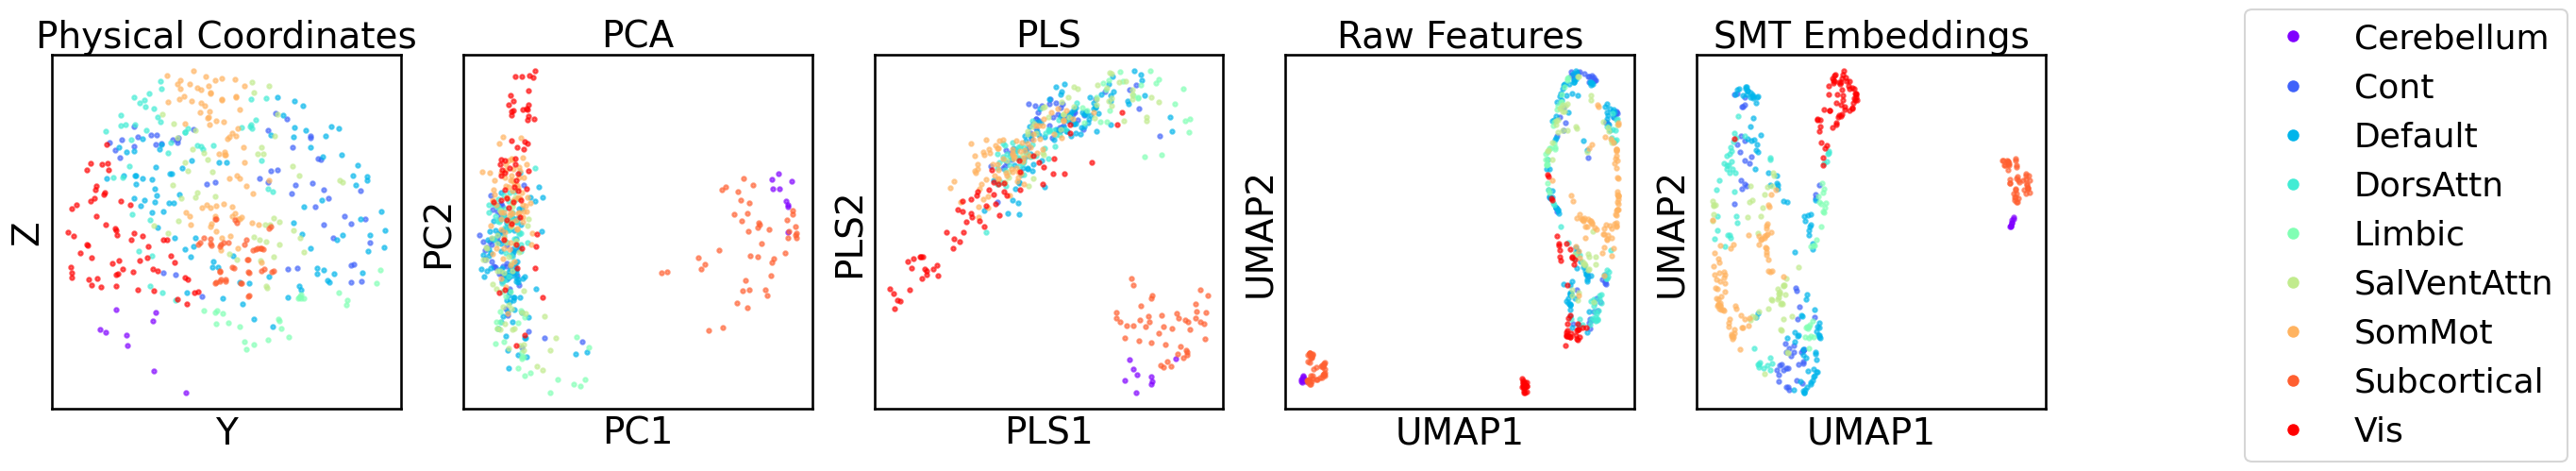

In [88]:
# Set global font size
FONTSIZE = 28

# Import UMAP
import umap

# Create UMAP embedding for the high-dimensional embeddings
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=20, spread=1.0)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# Create UMAP embedding for raw features
X_umap = umap_reducer.fit_transform(X)

# Set up the figure with 5 subplots in a row
fig, axs = plt.subplots(1, 5, figsize=(22, 5))
#fig.suptitle('2D Visualizations of Different Representations', fontsize=FONTSIZE+2)

# Get unique networks for coloring
unique_networks = np.unique(network_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))
network_to_color = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = np.array([network_to_color[label] for label in network_labels])

# Plot coordinates (using first 2 dimensions)
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[0].scatter(coords[mask, 1], coords[mask, 2], 
                  color=color, alpha=0.6, s=10)
axs[0].set_title('Physical Coordinates', fontsize=FONTSIZE, pad=5)
axs[0].set_xlabel('Y', fontsize=FONTSIZE, labelpad=5)
axs[0].set_ylabel('Z', fontsize=FONTSIZE, labelpad=5)
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot PCA
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[1].set_title('PCA', fontsize=FONTSIZE, pad=5)
axs[1].set_xlabel('PC1', fontsize=FONTSIZE, labelpad=5)
axs[1].set_ylabel('PC2', fontsize=FONTSIZE, labelpad=5)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Plot PLS
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[2].scatter(X_pls[mask, 0], X_pls[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[2].set_title('PLS', fontsize=FONTSIZE, pad=5)
axs[2].set_xlabel('PLS1', fontsize=FONTSIZE, labelpad=5)
axs[2].set_ylabel('PLS2', fontsize=FONTSIZE, labelpad=5)
axs[2].set_xticks([])
axs[2].set_yticks([])

# Plot UMAP of raw features
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[3].scatter(X_umap[mask, 0], X_umap[mask, 1],
                  color=color, alpha=0.6, s=10)
axs[3].set_title('Raw Features', fontsize=FONTSIZE, pad=5)
axs[3].set_xlabel('UMAP1', fontsize=FONTSIZE, labelpad=5)
axs[3].set_ylabel('UMAP2', fontsize=FONTSIZE, labelpad=5)
axs[3].set_xticks([])
axs[3].set_yticks([])

# Plot UMAP of learned embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[4].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[4].set_title('SMT Embeddings', fontsize=FONTSIZE, pad=5)
axs[4].set_xlabel('UMAP1', fontsize=FONTSIZE, labelpad=5)
axs[4].set_ylabel('UMAP2', fontsize=FONTSIZE, labelpad=5)
axs[4].set_xticks([])
axs[4].set_yticks([])

# Add legend on the right
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color,
                            label=network,
                            markersize=10)
                  for network, color in zip(unique_networks, colors)]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=FONTSIZE-2)

# Adjust layout to prevent overlap
plt.tight_layout()


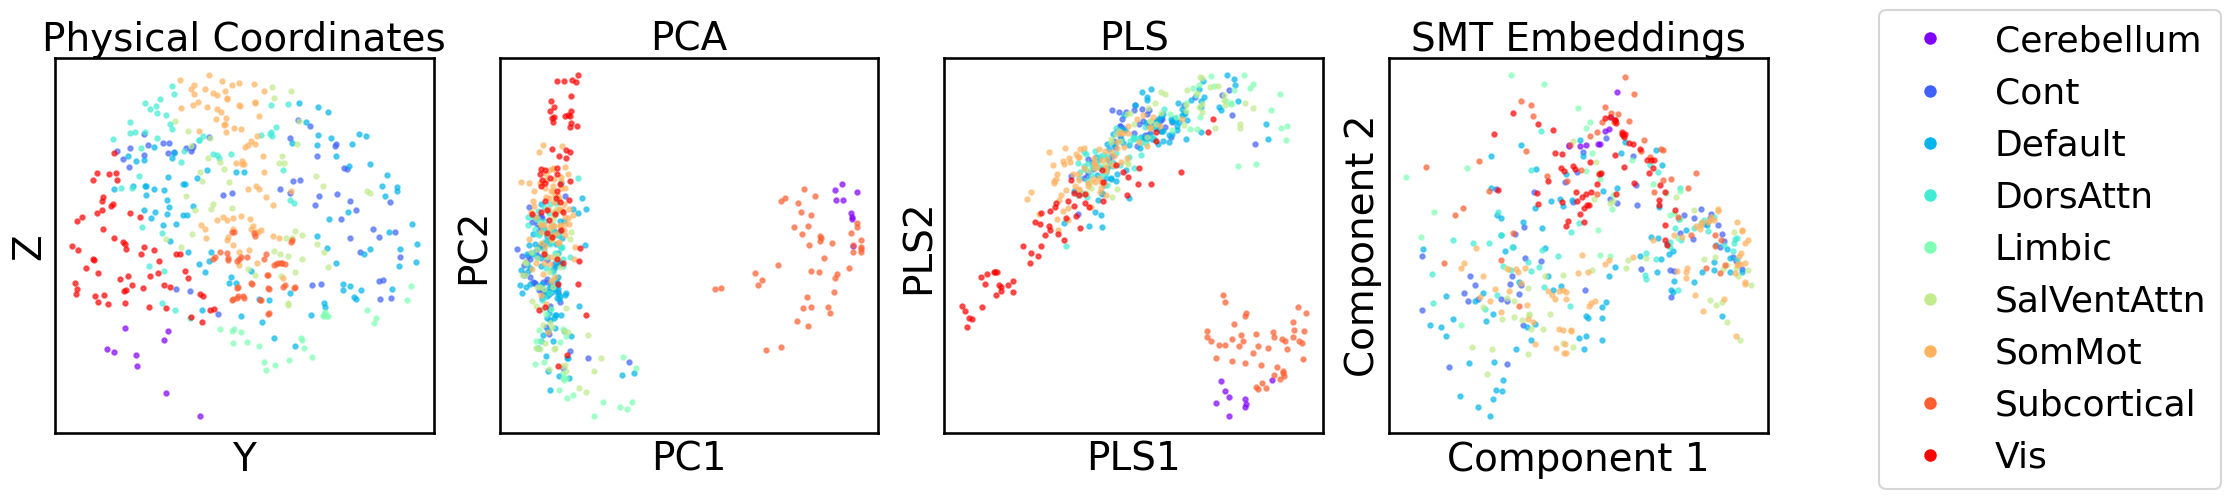

In [86]:
# Set global font size
FONTSIZE = 28

# Set up the figure with 4 subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
#fig.suptitle('2D Visualizations of Different Representations', fontsize=FONTSIZE+2)

# Get unique networks for coloring
unique_networks = np.unique(network_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))
network_to_color = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = np.array([network_to_color[label] for label in network_labels])

# Plot coordinates (using first 2 dimensions)
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[0].scatter(coords[mask, 1], coords[mask, 2], 
                  color=color, alpha=0.6, s=10)
axs[0].set_title('Physical Coordinates', fontsize=FONTSIZE, pad=5)
axs[0].set_xlabel('Y', fontsize=FONTSIZE, labelpad=5)
axs[0].set_ylabel('Z', fontsize=FONTSIZE, labelpad=5)
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot PCA
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[1].set_title('PCA', fontsize=FONTSIZE, pad=5)
axs[1].set_xlabel('PC1', fontsize=FONTSIZE, labelpad=5)
axs[1].set_ylabel('PC2', fontsize=FONTSIZE, labelpad=5)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Plot PLS
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[2].scatter(X_pls[mask, 0], X_pls[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[2].set_title('PLS', fontsize=FONTSIZE, pad=5)
axs[2].set_xlabel('PLS1', fontsize=FONTSIZE, labelpad=5)
axs[2].set_ylabel('PLS2', fontsize=FONTSIZE, labelpad=5)
axs[2].set_xticks([])
axs[2].set_yticks([])

# Plot first 2 components of embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs[3].scatter(embeddings[mask, 0], embeddings[mask, 1], 
                  color=color, alpha=0.6, s=10)
axs[3].set_title('SMT Embeddings', fontsize=FONTSIZE, pad=5)
axs[3].set_xlabel('Component 1', fontsize=FONTSIZE, labelpad=5)
axs[3].set_ylabel('Component 2', fontsize=FONTSIZE, labelpad=5)
axs[3].set_xticks([])
axs[3].set_yticks([])

# Add legend on the right
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color,
                            label=network,
                            markersize=10)
                  for network, color in zip(unique_networks, colors)]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=FONTSIZE-2)

# Adjust layout to prevent overlap
plt.tight_layout()
